In [1]:
import warnings
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')


# Datasets

## Stage incidence

In [2]:
st_df = pd.read_csv('./final_dataset/stage_incidence.csv').dropna()

In [3]:
st_df.head()

,year,region,mtumors,syncmtumors,insitu,ncervix,nhospotal,nbeds,ybeds,nill,...,ndialysis,gdp,air_pollution,polluted_dumps,not_cleaned_dumps,dumps_not_cleaned_enough,num_clearing_plants,cpi,population,tincidence
0,2010,Вінницька,356,112,113,103,109,12441,12423.0,368335,...,1,14332.0,103.0,2.0,0.0,2.0,98.0,109.1,1650608.0,5587
1,2010,Волинська,177,50,81,77,52,7653,7650.0,229994,...,2,13916.0,8.2,4.0,1.0,3.0,78.0,109.1,1036665.0,2845
2,2010,Дніпропетровська,767,212,174,150,155,29713,29892.0,805622,...,1,34709.0,933.1,504.0,133.0,371.0,983.0,109.1,3355481.0,12310
3,2010,Донецька,906,234,57,24,173,32134,32193.0,893383,...,6,28986.0,1378.1,550.0,17.0,533.0,1511.0,109.1,4466740.0,15088
4,2010,Житомирська,285,94,33,30,69,8621,8635.9,282862,...,1,14616.0,18.4,6.0,0.0,6.0,104.0,109.1,1285849.0,3957


In [4]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 359
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      312 non-null    int64  
 1   region                    312 non-null    object 
 2   mtumors                   312 non-null    int64  
 3   syncmtumors               312 non-null    int64  
 4   insitu                    312 non-null    int64  
 5   ncervix                   312 non-null    int64  
 6   nhospotal                 312 non-null    int64  
 7   nbeds                     312 non-null    int64  
 8   ybeds                     312 non-null    float64
 9   nill                      312 non-null    int64  
 10  nvillage_ill              312 non-null    int64  
 11  bed_days                  312 non-null    int64  
 12  dvisits                   312 non-null    int64  
 13  hvisits                   312 non-null    int64  
 14  ndoctors       

In [5]:
numeric_columns = st_df.select_dtypes(include=['number']).columns
st_df[numeric_columns] = st_df[numeric_columns].astype(float)

# EDA

In [6]:
def plot_ts(ts, column_name, title):
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=ts['year'], y=ts[column_name], linewidth=2.5, marker='o', markersize=5)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()


def plot_scatter(ts, column_name: str, title: str):
    plt.figure(figsize=(12, 6))

    sns.scatterplot(x=ts['year'], y=ts[column_name])
    
    plt.title(title, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column_name, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()



def plot_summary_ts_for_columns(df: pd.DataFrame, columns: list[str]):
    cols = 5 if len(columns) > 5 else len(columns)
    rows = len(columns) // 5 
    rows += 1 if len(columns) % 5 else 0

    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ts = df[['year', column]]

        sns.lineplot(x=ts['year'], y=ts[column], linewidth=2.5, color='b', marker='o', markersize=5, ax=ax)

        ax.set_title(column, fontsize=14)

        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([]) 
        ax.set_yticklabels([])

        ax.grid(True)
    
    plt.show()


def plot_ts_for_each_region(df: pd.DataFrame, column: str, title: str, scales: bool = False):
    regions = df.region.unique()
    cols = 5 if len(regions) > 5 else len(regions)
    rows = len(regions) // 5 
    rows += 1 if len(regions) % 5 else 0

    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    
    fig.suptitle(title)

    axes = axes.flatten()

    for i, region in enumerate(regions):
        ax = axes[i]
        ts = df[df.region == region][['year', column]]

        sns.lineplot(x=ts['year'], y=ts[column], linewidth=2.5, color='b', marker='o', markersize=5, ax=ax)

        ax.set_title(region, fontsize=14)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if not scales:
            ax.set_xticklabels([]) 
            ax.set_yticklabels([])

        ax.grid(True)

    fig.subplots_adjust(top=0.95)
    
    plt.show()


def plot_ts_for_region(ts: pd.DataFrame, column: str, region: str):
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=ts['year'], y=ts[ts.region == region][column], linewidth=2.5, color='b', marker='o', markersize=5)
    
    plt.title(column, fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show


In [7]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 0 to 359
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      312 non-null    float64
 1   region                    312 non-null    object 
 2   mtumors                   312 non-null    float64
 3   syncmtumors               312 non-null    float64
 4   insitu                    312 non-null    float64
 5   ncervix                   312 non-null    float64
 6   nhospotal                 312 non-null    float64
 7   nbeds                     312 non-null    float64
 8   ybeds                     312 non-null    float64
 9   nill                      312 non-null    float64
 10  nvillage_ill              312 non-null    float64
 11  bed_days                  312 non-null    float64
 12  dvisits                   312 non-null    float64
 13  hvisits                   312 non-null    float64
 14  ndoctors       

### Feature engineering

In [8]:

st_f_df = st_df.copy()

population_th = st_f_df.population / 100000
st_f_df['mtumors_pht'] = st_f_df.mtumors / population_th
st_f_df['syncmtumors_pht'] = st_f_df.syncmtumors / population_th
st_f_df['insitu_pht'] = st_f_df.insitu / population_th
st_f_df['insitu_pti'] = st_f_df.insitu / (st_f_df['tincidence'] / 1000)
st_f_df['mtumors_pti'] = st_f_df.mtumors / (st_f_df['tincidence'] / 1000)


population_related_columns = ['nhospotal', 'nbeds', 'ybeds', 'nill', 'nvillage_ill', 'bed_days', 'dvisits', 'hvisits', 'ndoctors', 
                              'nnursing', 'nx_ray', 'nflurography', 'nradiology', 'nradlab', 'nсt', 'ncardiogram', 'ndiaglab',
                              'nbacter', 'nbiochem', 'ncyto', 'nimun', 'nphysic', 'nendoscop', 'nultrasound', 'ndialysis',
                              'tincidence']

for column in population_related_columns:
    st_f_df[column] = (st_f_df[column] / population_th).round(4)


st_f_df = st_f_df.rename(columns={column: f"{column}_pht" for column in population_related_columns})

---
# GDP

In [9]:
gdp_4_18_df = pd.read_csv("./final_dataset/grp_per_capita_to_del.csv").rename(columns={"Unnamed: 0": "region"}).melt(id_vars="region", var_name="year", value_name="gdp")
gdp_4_18_df["year"] = gdp_4_18_df["year"].astype(int)

In [10]:
gdp_19_21_df =pd.read_csv("./final_dataset/gdp_19-21.csv").rename(columns={"Територіальний розріз": "region", "Період": "year", "Значення cпостереження": "gdp"})

gdp_19_21_df.columns, gdp_4_18_df.columns

(Index(['region', 'year', 'gdp'], dtype='object'),
 Index(['region', 'year', 'gdp'], dtype='object'))

In [11]:

gdp_4_18_df.head()
gdp_df = pd.concat([gdp_4_18_df, gdp_19_21_df], ignore_index=True)
gdp_df.to_csv("./final_dataset/gdp.csv", index=False)

---

In [12]:
mean_age_df = pd.read_csv("./final_dataset/mean_age.csv")
print(mean_age_df.columns)

mean_age_wide = (
    mean_age_df
      .pivot_table(
         index=["Територіальний розріз", "Період"],
         columns="Показник",
         values="Значення cпостереження",
         aggfunc="first"
      )
      .reset_index()
      .rename(columns={
         "Територіальний розріз": "region",
         "Період": "year",
         "Середній вік населення станом на 1 січня": "mean_age",
         "Рівень старіння населення станом на 1 січня": "aging_level"
      })
)

mean_age_wide.columns.name = None
mean_age_df = mean_age_wide

Index(['Показник', 'Територіальний розріз', 'Період',
       'Значення cпостереження'],
      dtype='object')


In [13]:
mean_age_df = mean_age_df[(mean_age_df.year >= 2008) & (mean_age_df.year <= 2021)]

In [14]:
st_f_df['year'] = st_f_df['year'].astype(int)

st_f_df = (
    st_f_df
    .drop(columns=["gdp"])
    .merge(gdp_df, on=["region", "year"], how="left")
    .merge(mean_age_df, on=["region", "year"], how="left")
)

In [15]:
st_f_df.to_csv("./final_dataset/stage_incidence_features.csv", index=False)

In [16]:
st_f_df.region.unique()

array(['Вінницька', 'Волинська', 'Дніпропетровська', 'Донецька',
       'Житомирська', 'Закарпатська', 'Запорізька', 'Івано-Франківська',
       'Київська', 'Кіровоградська', 'Луганська', 'Львівська',
       'Миколаївська', 'Одеська', 'Полтавська', 'Рівненська', 'Сумська',
       'Тернопільська', 'Харківська', 'Херсонська', 'Хмельницька',
       'Черкаська', 'Чернівецька', 'Чернігівська'], dtype=object)

### Big picture

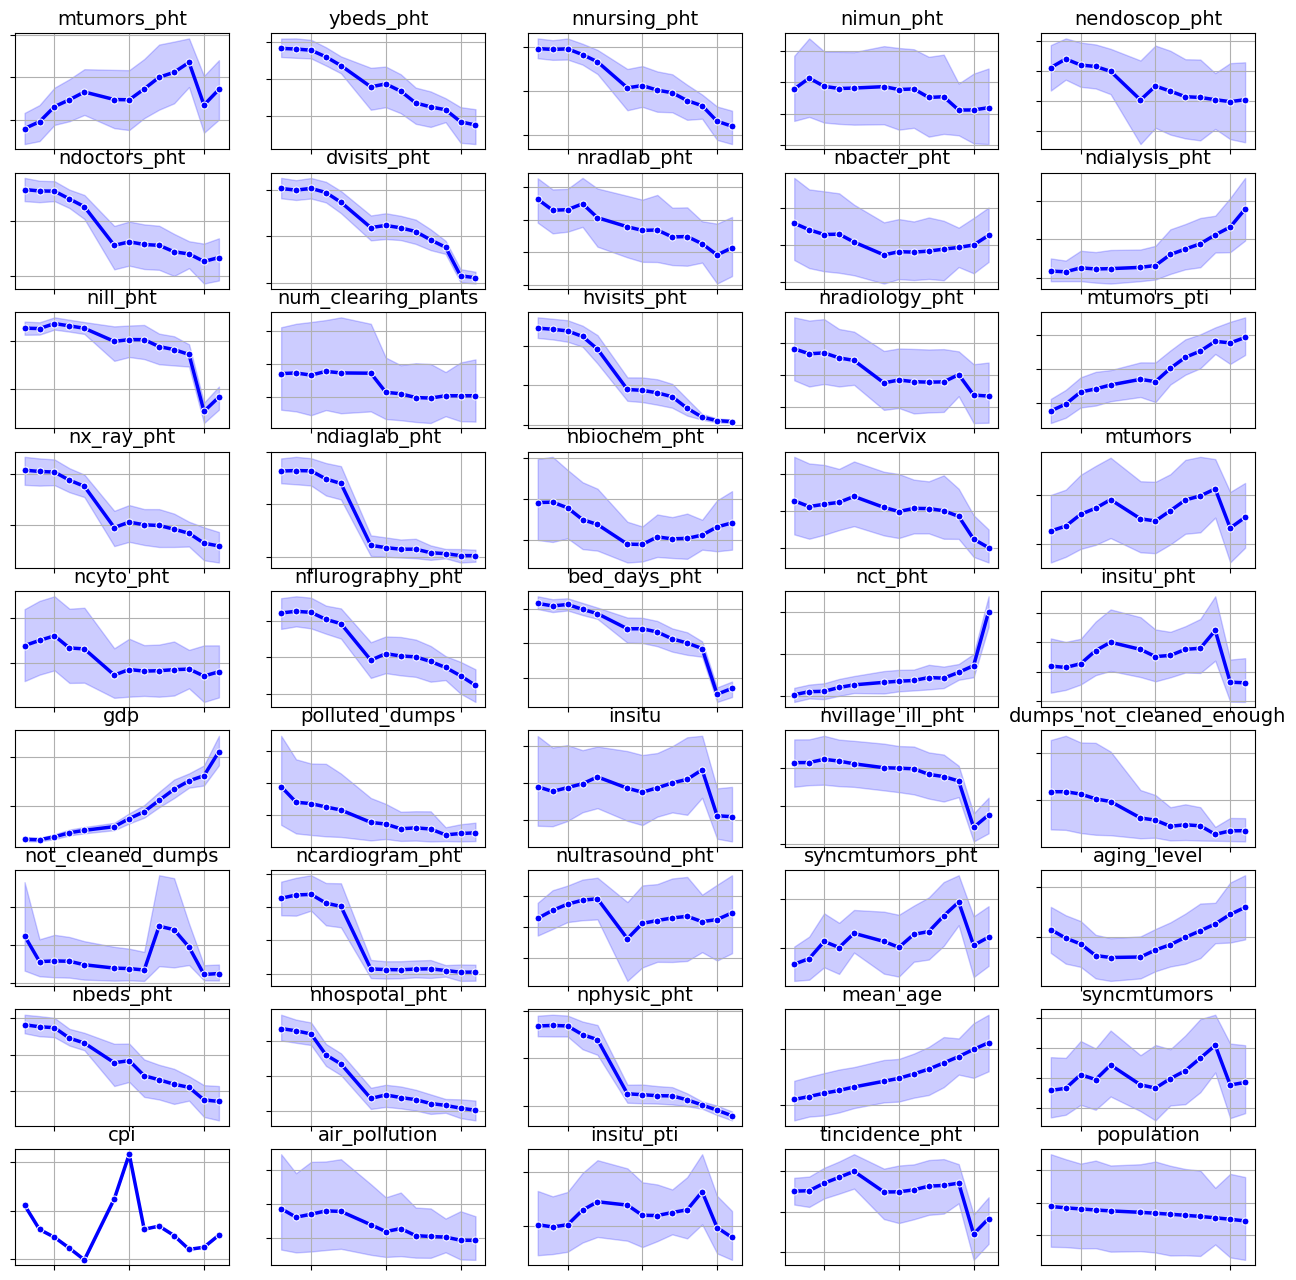

In [17]:
columns_to_show = set(st_f_df.columns) - set(['year', 'region', 't']) 
plot_summary_ts_for_columns(st_f_df, columns_to_show)

### Radiology labolatories

array([[<Axes: title={'center': 'ncyto'}>,
        <Axes: title={'center': 'nradiology'}>],
       [<Axes: title={'center': 'nimun'}>,
        <Axes: title={'center': 'nbiochem'}>]], dtype=object)

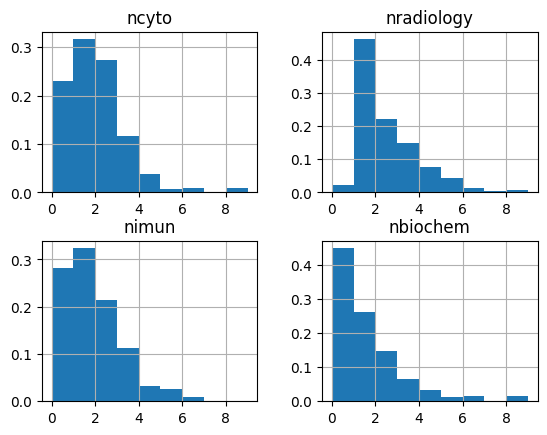

In [52]:
st_df[['region', 'ncyto', 'nradiology', 'nimun', 'nbiochem']].hist(density=True, bins=range(0, 10))

In [ ]:
st_df[st_df.nbiochem == 0]

139

### Selected dependent time series

1. **Insitu tumors per 1000 diagnosed cancer**

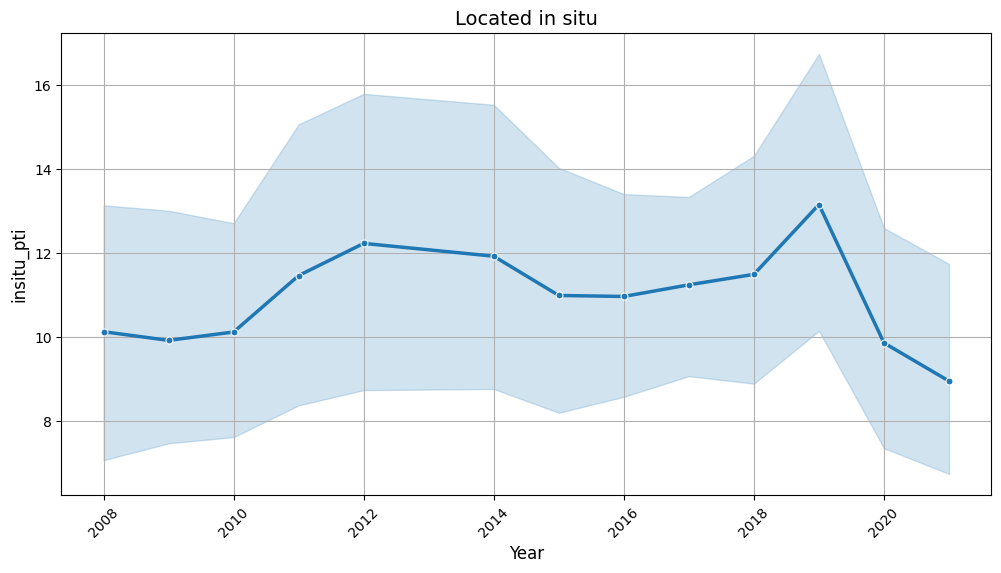

In [19]:
plot_ts(st_f_df, 'insitu_pti', "Located in situ")

2. **Multiple tumors per 1000 diagnosed cancer**

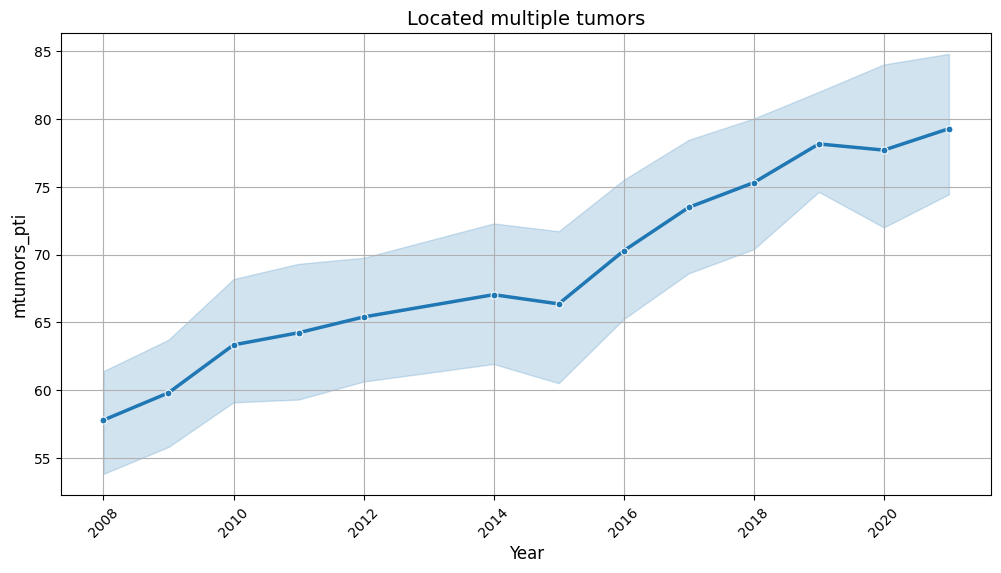

In [20]:
plot_ts(st_f_df, 'mtumors_pti', "Located multiple tumors")

In [21]:
st_f_df.columns

Index(['year', 'region', 'mtumors', 'syncmtumors', 'insitu', 'ncervix',
       'nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
       'nvillage_ill_pht', 'bed_days_pht', 'dvisits_pht', 'hvisits_pht',
       'ndoctors_pht', 'nnursing_pht', 'nx_ray_pht', 'nflurography_pht',
       'nradiology_pht', 'nradlab_pht', 'nсt_pht', 'ncardiogram_pht',
       'ndiaglab_pht', 'nbacter_pht', 'nbiochem_pht', 'ncyto_pht', 'nimun_pht',
       'nphysic_pht', 'nendoscop_pht', 'nultrasound_pht', 'ndialysis_pht',
       'air_pollution', 'polluted_dumps', 'not_cleaned_dumps',
       'dumps_not_cleaned_enough', 'num_clearing_plants', 'cpi', 'population',
       'tincidence_pht', 'mtumors_pht', 'syncmtumors_pht', 'insitu_pht',
       'insitu_pti', 'mtumors_pti', 'gdp', 'aging_level', 'mean_age'],
      dtype='object')

### Detrending

In [22]:
st_f_df = st_f_df

In [23]:
st_f_df['t'] = st_f_df['year'] - 2008

Tests for stationarity:

In [24]:

def test_stationarity(ts: pd.Series):
    result = adfuller(ts)
    print(f"p-value: {result[1]}")
    
    if result[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Failed to reject the null hypothesis")


def test_stationarity_for_regions(df: pd.DataFrame, column: str) -> list[str]:
    regions = df.region.unique()
    unstationary_ts = []

    for region in regions:
        ts = df[df.region == region].sort_values(by='year')[column]
        
        if len(set(ts)) == 1:
            continue

        result = adfuller(ts)
        
        pvalue = result[1]

        if pvalue > 0.05:
            unstationary_ts.append(region)

    return unstationary_ts


def get_nonstationary_features(df: pd.DataFrame, columns_to_investigate: list[str]) -> dict[str, list[str]]:
    non_stationary_features = {}

    for column in columns_to_investigate:
        nonstationary_regions = test_stationarity_for_regions(df, column)
        if nonstationary_regions:
            non_stationary_features[column] = nonstationary_regions
    return non_stationary_features


In [25]:
def test_stationarity_for_regions(df, column):

    unstationary_ts = []
    regions = df.region.unique()
    
    for region in regions:
        ts = df[df.region == region].sort_values(by='year')[column]
        
        if len(set(ts)) == 1:
            continue

        result = adfuller(ts)
        
        pvalue = result[1]

        if pvalue > 0.05:
            unstationary_ts.append(region)

    return unstationary_ts


def get_nonstationary_features(df: pd.DataFrame, columns_to_investigate: list[str]) -> dict[str, list[str]]:
    non_stationary_features = {}

    for column in columns_to_investigate:
        nonstationary_regions = test_stationarity_for_regions(df, column)
        if nonstationary_regions:
            non_stationary_features[column] = nonstationary_regions
    return non_stationary_features


Search for variables that need detrending

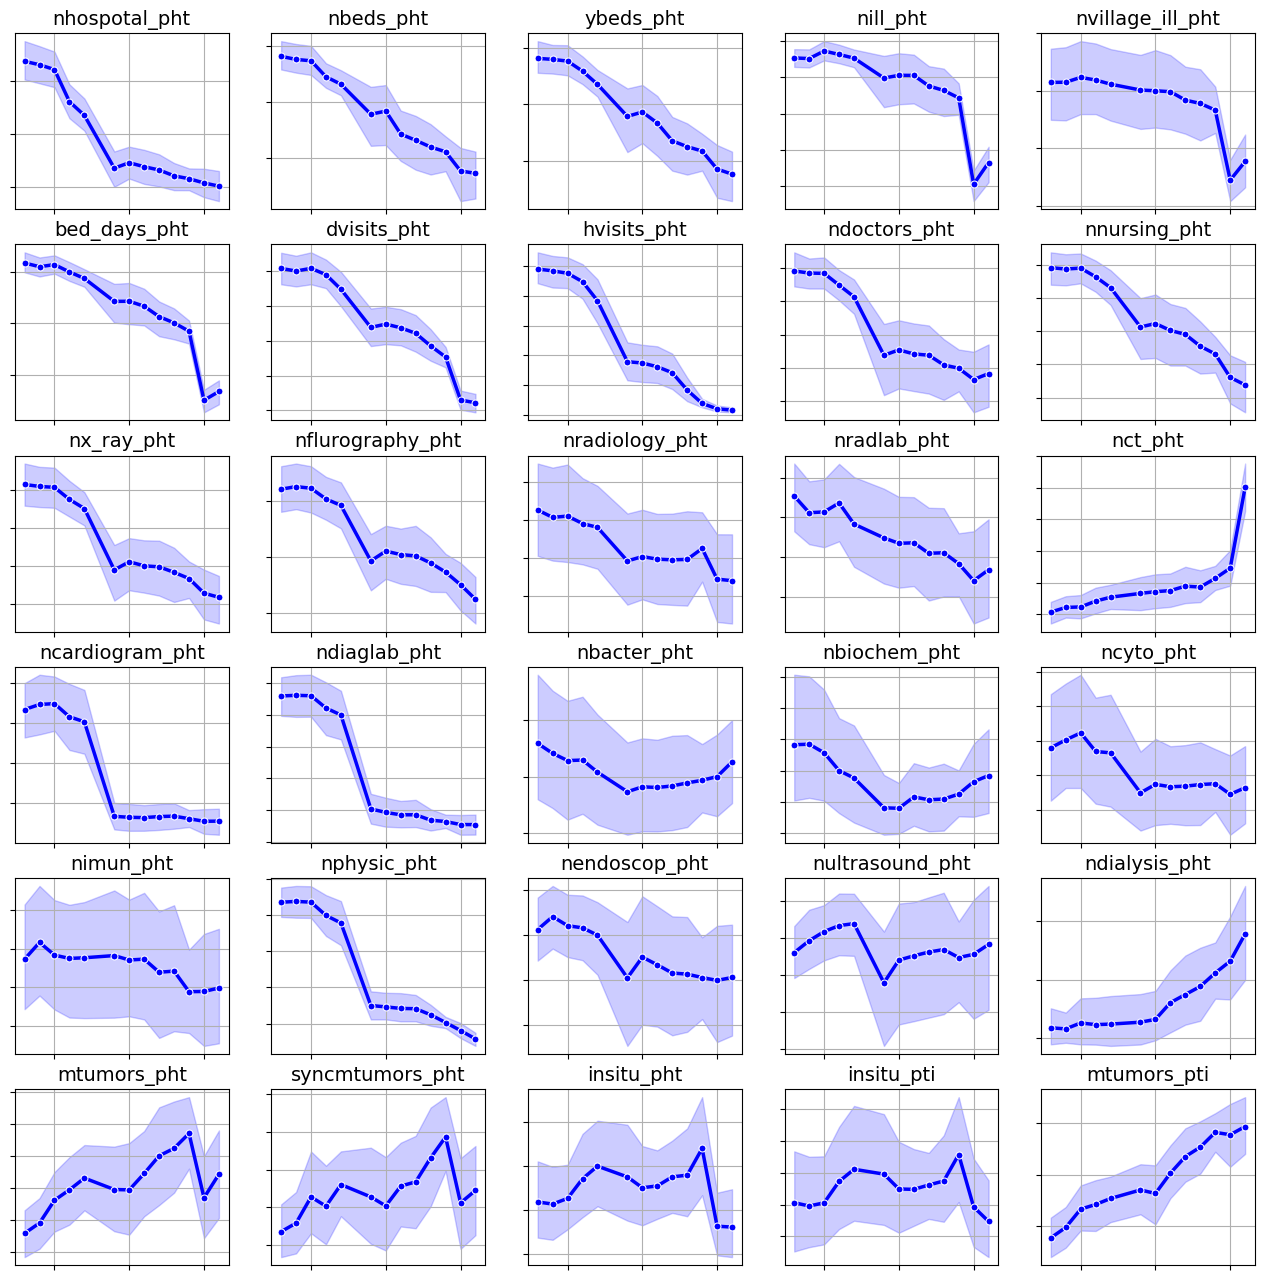

In [26]:
candidate_columns_to_detrend = ['nhospotal_pht', 'nbeds_pht', 'ybeds_pht', 'nill_pht',
                                'nvillage_ill_pht', 'bed_days_pht', 'dvisits_pht', 'hvisits_pht', 'ndoctors_pht', 'nnursing_pht', 'nx_ray_pht', 
                                'nflurography_pht', 'nradiology_pht', 'nradlab_pht', 'nсt_pht', 'ncardiogram_pht', 'ndiaglab_pht', 'nbacter_pht', 
                                'nbiochem_pht', 'ncyto_pht', 'nimun_pht', 'nphysic_pht', 'nendoscop_pht', 'nultrasound_pht', 'ndialysis_pht',
                                'mtumors_pht', 'syncmtumors_pht', 'insitu_pht', 'insitu_pti', 'mtumors_pti',]


plot_summary_ts_for_columns(st_f_df, candidate_columns_to_detrend)

Detrending techniques:

In [27]:
def linear_regression_detrend(ts: pd.Series):
    X = sm.add_constant(range(len(ts)))
    trend_model = sm.OLS(ts, X).fit()
    return trend_model.resid


def quadratic_regression_detrend(ts: pd.Series):
    t = pd.Series(range(len(ts)))
    ts = ts.reset_index(drop=True)
    X = pd.DataFrame({'t': t, 'tsq': t})
    X['tsq'] = X['tsq'] ** 2
    X = sm.add_constant(X)
    trend_model = sm.OLS(ts, X).fit()
    return trend_model.resid

def qubic_regression_detrend(ts: pd.Series):
    t = pd.Series(range(len(ts)))
    ts = ts.reset_index(drop=True)
    X = pd.DataFrame({'t': t, 'tsq': t, 'tcb': t})
    X['tsq'] = X['tsq'] ** 2
    X['tcb'] = X['tcb'] ** 3
    X = sm.add_constant(X)
    trend_model = sm.OLS(ts, X).fit()
    return trend_model.resid

def moving_average_detrend(ts: pd.Series):
    moving_average = ts.rolling(window=3, center=True).mean().ffill().bfill()
    return ts - moving_average 


def differencing_detrend(ts: pd.Series):
    detrended_ts = ts.diff()
    detrended_ts.iloc[0] = detrended_ts.iloc[1]
    return detrended_ts


def detrend_column_for(df: pd.DataFrame, column, region, detrend_function):
    years = sorted(df.year.unique())
    ts = df[df.region == region].sort_values(by='year')[column]
    detrended_ts = detrend_function(ts)
    for i, year in enumerate(years):
        df.loc[(df.region == region) & (df.year == year), column] = detrended_ts.iloc[i]


def select_best_detrending_function(df, features: dict[str, list[str]]):
    detrending_functions = [linear_regression_detrend, quadratic_regression_detrend, qubic_regression_detrend,
                            moving_average_detrend, differencing_detrend]

    best_detrendors = {column: linear_regression_detrend for column in features}

    for column in features.keys():
        non_stationary_regions = features[column]
        
        for function in detrending_functions:
            column_df = df[['year', 'region', column]].copy()
            column_df = detrend_column_with(column_df, column, function)
            non_stationary_ad_ts = test_stationarity_for_regions(column_df, column)

            if len(non_stationary_ad_ts) < len(non_stationary_regions):
                non_stationary_regions = non_stationary_ad_ts
                best_detrendors[column] = function

    return best_detrendors 


def detrend_column_with(df: pd.DataFrame, column: str, detrend_function):
    regions = df.region.unique()
    for region in regions:
        detrend_column_for(df, column, region, detrend_function)
    return df

Select best detrending techniques

In [28]:
detrended_df = st_f_df.copy()
non_stationary_features = get_nonstationary_features(st_f_df, candidate_columns_to_detrend)
best_detrendors = select_best_detrending_function(st_f_df, non_stationary_features)

for column in non_stationary_features:
    detrended_df = detrend_column_with(detrended_df, column, best_detrendors[column])

nonstationary = get_nonstationary_features(detrended_df, candidate_columns_to_detrend)
regions = detrended_df.region.unique()
stationary_regions = []

for region in regions:
    if all(region not in ns_region for ns_region in nonstationary.values()):
        stationary_regions.append(region)

print(stationary_regions)
pd.DataFrame({"columns": nonstationary.keys(), "counts": map(len, nonstationary.values())})

[]


,columns,counts
0,nhospotal_pht,6
1,nbeds_pht,7
2,ybeds_pht,8
3,nill_pht,12
4,nvillage_ill_pht,13
5,bed_days_pht,10
6,dvisits_pht,7
7,hvisits_pht,14
8,ndoctors_pht,9
9,nnursing_pht,8


In [29]:
detrended_df.to_csv("./final_dataset/stage_incidence_detrended.csv")

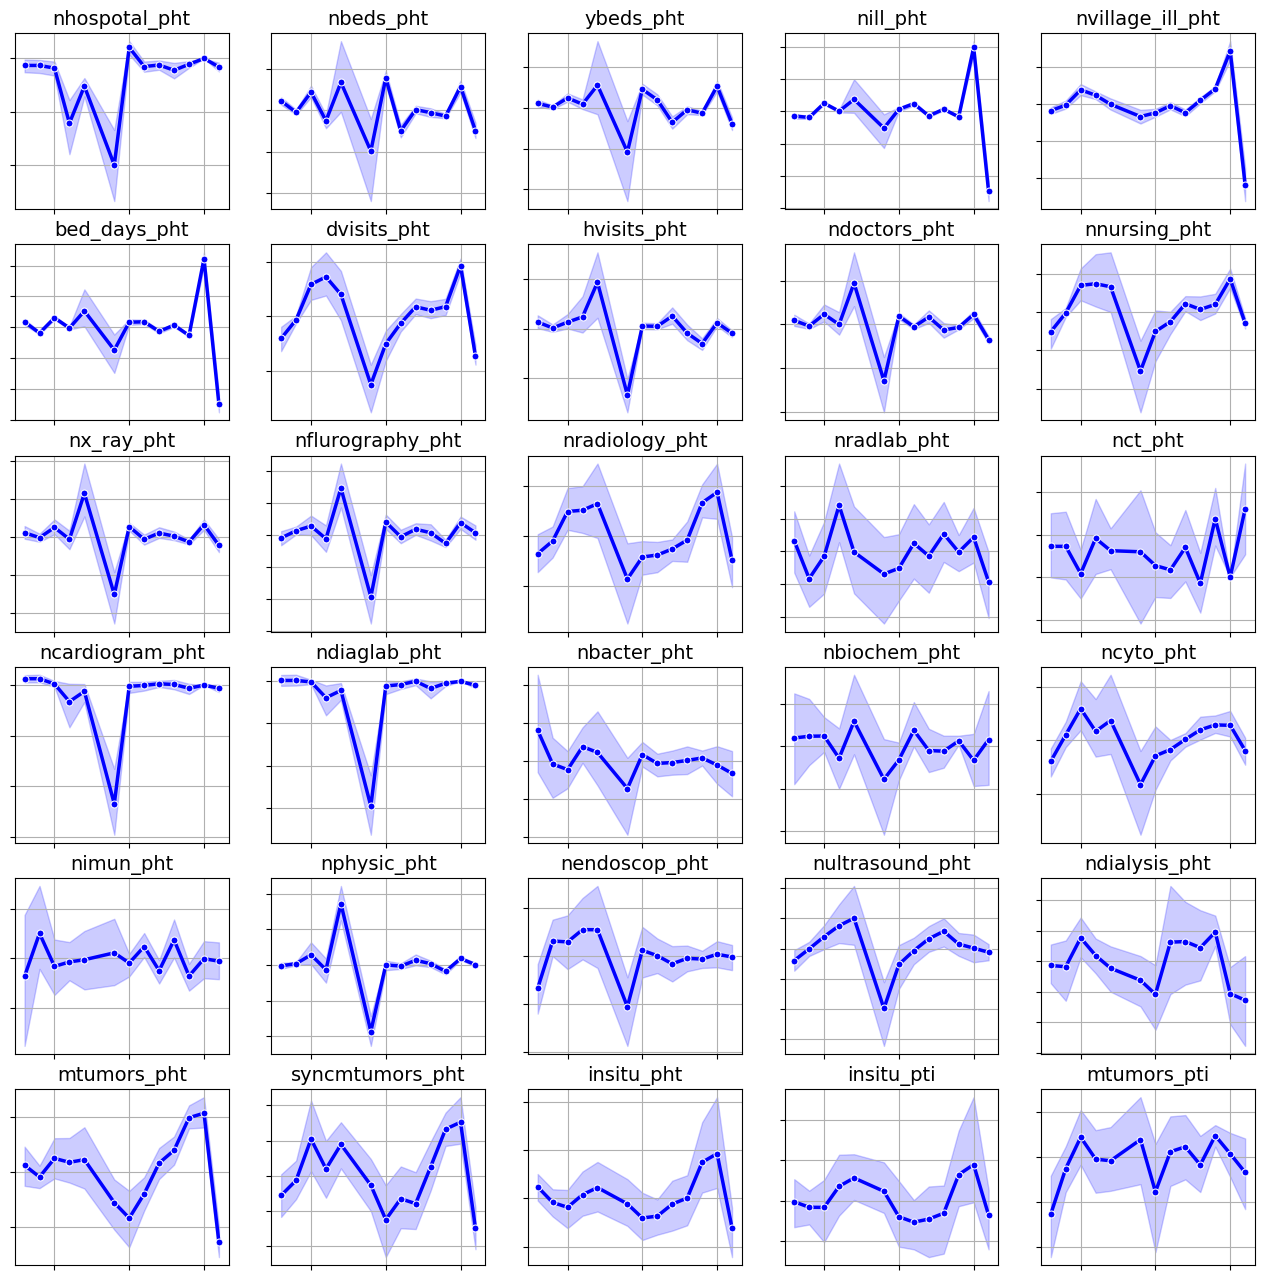

In [30]:
plot_summary_ts_for_columns(detrended_df, candidate_columns_to_detrend)